## california data (linear regression data)

### variable selection
- forward selection

In [1]:
%load_ext watermark
%watermark -a '201720723 박수린' -u -d -p numpy,pandas,matplotlib,seaborn,sklearn,pydotplus

201720723 박수린 
last updated: 2020-06-09 

numpy 1.18.1
pandas 1.0.2
matplotlib 3.1.3
seaborn 0.10.0
sklearn 0.0
pydotplus 2.0.2


In [2]:
from sklearn.datasets import fetch_california_housing
# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context
california = fetch_california_housing()
# print(california.DESCR)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(california.data, california.target, test_size = 0.1, random_state=100)

In [4]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# x_train, x_test을 Dataframe으로 변환 
X = pd.DataFrame(x_train, columns=california.feature_names)
X_test = pd.DataFrame(x_test, columns=california.feature_names)
y = y_train

# adjusted r2 score 계산을 위한 함수
def calculate_adj_r2(n, p, score_r2) :
    adj = (n-1)*(1-score_r2)/(n-p-1)
    return 1-adj

# forward selection을 위한 함수 
# 최종 선택된 feature들의 list인 included를 반환
def forward_selection(X, y, initial_list=[]) :
    # 처음에는 비어있는 list
    included = list(initial_list)
    # feature를 추가했는데 성능이 좋아지지 않았다면 멈춰야함 
    # old score 초기화
    old_score = 0

    # include 속 feature 개수는 4개 까지
    while len(included) < 4:
        # feature에서 included에 포함되지 않은 list
        excluded = list(set(X.columns)-set(included))
        # adjusted r2 score의 max를 찾기 위해
        # excluded에 있는 feature들로 이루어진 비어있는 Series 만들기
        new_adj_r2 = pd.Series(index=excluded)
        # 아직 포함되지 않은 feature list에서 feature들을 하나씩 포함해가며 score 계산
        for new_column in excluded:
            model = LinearRegression().fit(X[included+[new_column]], y)
            y_pred = model.predict(X_test[included+[new_column]])
            n = X_test[included+[new_column]].shape[0]
            p = X_test[included+[new_column]].shape[1]
            new_adj_r2[new_column] = calculate_adj_r2(n, p, metrics.r2_score(y_test, y_pred))
        # excluded에 있는 feature들 중 가장 성능이 높은 score 찾기
        new_score = new_adj_r2.max()
        # 만약 성능이 더 좋아졌다면 included 리스트에 추가
        # old score 업데이트
        if(old_score < new_score):
            best_feature = new_adj_r2.index[new_adj_r2.argmax()]
            included.append(best_feature)
            old_score = new_score
        # 성능이 좋아지지 않았다면 멈춤
        else:
            break
    return included

In [5]:
# 최종 선택된 feature들 출력
result = forward_selection(X, y)
print(result)

['MedInc', 'HouseAge', 'Latitude', 'Longitude']


In [6]:
# forward selection을 진행한 후, 다시 학습 시킨 뒤 test R2 score 출력
linear_forward = LinearRegression().fit(X[result], y)
y_pred = linear_forward.predict(X_test[result])
print(metrics.r2_score(y_test, y_pred))

0.6003130522363483


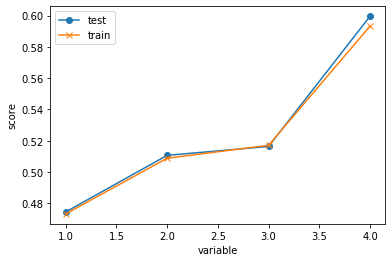

In [7]:
import matplotlib.pyplot as plt

origin = []
test_adj_r2_score = []
train_adj_r2_score = []

for new_column in result:
    # 모델 학습
    model = LinearRegression().fit(X[origin+[new_column]], y)

    # training score 계산
    y_pred = model.predict(X[origin+[new_column]])
    n = X[origin+[new_column]].shape[0]
    p = X[origin+[new_column]].shape[1]
    train_adj_r2_score.append(calculate_adj_r2(n, p, metrics.r2_score(y_train, y_pred)))

    # test score 계산
    y_pred = model.predict(X_test[origin+[new_column]])
    n = X_test[origin+[new_column]].shape[0]
    p = X_test[origin+[new_column]].shape[1]
    test_adj_r2_score.append(calculate_adj_r2(n, p, metrics.r2_score(y_test, y_pred)))

    # feature 개수를 늘려가며 모델 학습 시키기
    origin.append(new_column)

# 그래프 그리기
plt.plot(range(1, len(result)+1), test_adj_r2_score, label="test", marker='o')
plt.plot(range(1, len(result)+1), train_adj_r2_score, label="train", marker='x')
plt.xlabel('variable')
plt.ylabel('score')
plt.legend()
plt.show()

### Regularized linear model
- cross validation (5-fold)

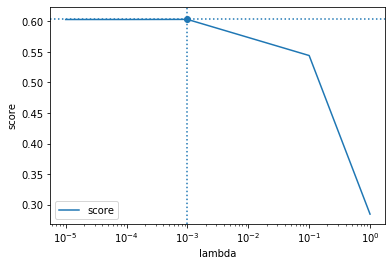

In [11]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Lasso의 Hyper parameter list
alphas = [0.00001, 0.0001, 0.001, 0.1, 1.0]
# score을 저장할 list
test_scores = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    # 5-fold cv를 한 score 계산
    # scoring 방법은 r2 사용
    test_score = np.mean(cross_val_score(model, x_train, y_train, scoring='r2', cv=5))
    test_scores.append(test_score)

# 가장 높은 score을 가지는 hyper parameter를 찾기
optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

# 그래프로 시각화하여 확인
plt.plot(alphas, test_scores, label='score')
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.ylabel('score')
plt.xlabel('lambda')
plt.xscale('log')
plt.legend()
plt.show()

In [12]:
# 성능이 좋은 hyper parmaeter 0.001로 모델 학습
lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
# 최종 r2 score 출력
print(metrics.r2_score(y_test, y_pred))

0.6112980173099987


## Logistic regrssion 용 데이터

In [13]:
#  해당 코드는 수정하지 마세요
from sklearn.datasets import make_classification

X, y = make_classification(n_features=8, n_informative=5,
                           n_redundant=3, n_clusters_per_class=1, random_state=4, n_samples =1000 )

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=100)

In [15]:
# correlation coefficient를 저장해두기 위함
coef_arr = []

# 8개의 feature에 대해 correlation coefficient 구하기
for i in range(0, 8):
    coef_arr.append(np.corrcoef(x_train[:,i], y_train)[0,1])

# correlation coefficient 출력
print(coef_arr)

[0.013185315338549573, -0.5838571545434588, 0.6118996378190301, 0.008798460032451844, 0.03326379502519979, 0.6957877084640585, 0.6441398116254413, 0.5903929576506285]


In [16]:
# correlation coefficient가 가장 낮은 3개의 feature의 Index 찾기
worst_feature_indexes = []

for i in range(0, 3):
    min_index = coef_arr.index(min(coef_arr))
    coef_arr[min_index] = 1
    worst_feature_indexes.append(min_index)

print(worst_feature_indexes)

[1, 3, 0]


In [17]:
# x_train을 DataFrame으로 만들어 worst feature들을 drop한다.
df_best = pd.DataFrame(x_train)
for worst_column in worst_feature_indexes:
    df_best.drop(worst_column, axis=1, inplace=True)
print(df_best)


2         4         5         6         7
0    0.807875 -0.912309  1.929876  1.853316  0.572239
1    2.295863  3.889272  0.034402  0.110733  1.219698
2    3.648233  5.355116 -0.046427  0.990059  2.120767
3   -0.840541  0.876955 -0.764811 -0.478783 -0.501746
4    2.574380  4.076547 -0.276728 -0.719937  1.425453
..        ...       ...       ...       ...       ...
895 -0.016561 -2.636733  1.619659  1.518365  0.375975
896 -1.340485 -0.420627 -2.057146 -1.085805 -0.590851
897  1.988128  2.118913  1.810232  2.549599  1.001737
898  0.200666  2.070806  0.295897 -1.414529  0.157075
899  3.648671  1.786408  0.377900  2.386178  2.845972

[900 rows x 5 columns]


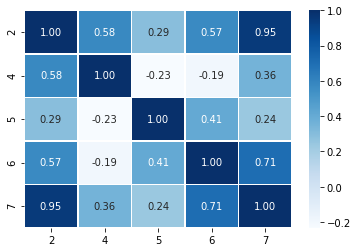

In [18]:
%matplotlib inline
import seaborn as sns
# heatmap 그리기
sns.heatmap(data = df_best.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()

In [19]:
from sklearn.linear_model import LogisticRegression

# test도 dataframe으로 변환하여 worst feature drop
df_best_test = pd.DataFrame(x_test)
for worst_column in worst_feature_indexes:
    df_best_test.drop(worst_column, axis=1, inplace=True)

In [20]:
# LogisticRegression model로 학습
logreg = LogisticRegression()
logreg.fit(df_best, y_train)
y_pred = logreg.predict(df_best_test)
# 최종 스코어 출력
print(metrics.accuracy_score(y_test, y_pred))

0.95
